# Training Notebook for VQ-VAE
To be run using on the Google Colab servers

### Global setup

In [ ]:
import os
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Connect to Github repository and import code

In [ ]:

!rm -rf VQ-VAE-Tranformer-Image-Gen

In [ ]:
# RUN THIS ONCE AT THE START OF THE SESSION
# clone github repository
!rm -rf VQ-VAE-Tranformer-Image-Gen

!git clone -b largeLatent https://github.com/Aivon99/VQ-VAE-Tranformer-Image-Gen.git

# add repo to sys path to allow imports
import sys
if '/content/VQ-VAE-Tranformer-Image-Gen' not in sys.path:
    sys.path.append('/content/VQ-VAE-Tranformer-Image-Gen')

print("Repo contents:", os.listdir())


Cloning into 'VQ-VAE-Tranformer-Image-Gen'...
remote: Enumerating objects: 243, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 243 (delta 52), reused 52 (delta 46), pack-reused 175 (from 1)
Receiving objects: 100% (243/243), 182.59 MiB | 41.97 MiB/s, done.
Resolving deltas: 100% (116/116), done.
Updating files: 100% (9/9), done.
Repo contents: ['.config', 'drive', 'VQ-VAE-Tranformer-Image-Gen', 'sample_data']


In [ ]:
# 1. Make sure we are in the repo root
%cd /content/VQ-VAE-Tranformer-Image-Gen

import os, sys
print("Current dir:", os.getcwd())
print("Top-level contents:", os.listdir())

print("VQ contents:", os.listdir("VQ"))

# 2. Add the *VQ folder itself* to sys.path
vq_path = "/content/VQ-VAE-Tranformer-Image-Gen/VQ"
if vq_path not in sys.path:
    sys.path.insert(0, vq_path)
print("sys.path now contains:", vq_path in sys.path)

# 3. Import model.py directly from that folder
import importlib
import model as vq_model
importlib.reload(vq_model)

from model import (
    Encoder, Decoder, Quantizer, VQ_VAE,
    LATENT_W, LATENT_H, IMG_H, IMG_W, NUM_EMBEDDINGS
)

print("✅ Imported model.py successfully")


/content/VQ-VAE-Tranformer-Image-Gen
Current dir: /content/VQ-VAE-Tranformer-Image-Gen
Top-level contents: ['TF_train.ipynb', 'VQ', '.gitignore', 'README.md', '.git', 'VQ_train.ipynb', 'TF']
VQ contents: ['model', 'model.py']
sys.path now contains: True
✅ Imported model.py successfully


In [ ]:
# pull changes from github

if '/content/VQ-VAE-Tranformer-Image-Gen' not in sys.path:
    sys.path.append('/content/VQ-VAE-Tranformer-Image-Gen')

print("Repo contents:", os.listdir())
%cd /content/VQ-VAE-Tranformer-Image-Gen
print("Current directory:", os.getcwd())

!git pull https://github.com/Aivon99/VQ-VAE-Tranformer-Image-Gen.git

# refrsh the imports
from importlib import reload

import VQ.model
reload(VQ.model)

from VQ.model import Encoder, Decoder, Quantizer, VQ_VAE, LATENT_W, LATENT_H, IMG_H, IMG_W, NUM_EMBEDDINGS

Repo contents: ['TF_train.ipynb', 'VQ', '.gitignore', 'README.md', '.git', 'VQ_train.ipynb', 'TF']
/content/VQ-VAE-Tranformer-Image-Gen
Current directory: /content/VQ-VAE-Tranformer-Image-Gen
From https://github.com/Aivon99/VQ-VAE-Tranformer-Image-Gen
 * branch            HEAD       -> FETCH_HEAD
Updating 3850f76..33a886b
Fast-forward
 TF/model.py                          |  35 ++++++++++++++++++++++++++++++-----
 TF_train.ipynb                       |   3 ++-
 VQ/model/celeba_vq_indices_uint16.pt | Bin 51867168 -> 0 bytes
 VQ/model/checkpoint.pt               | Bin 98594036 -> 0 bytes
 4 files changed, 32 insertions(+), 6 deletions(-)
 delete mode 100644 VQ/model/celeba_vq_indices_uint16.pt
 delete mode 100644 VQ/model/checkpoint.pt


### Load CelebA dataset

Dataset URL: https://www.kaggle.com/datasets/zuozhaorui/celeba
License(s): unknown
 99% 2.61G/2.64G [00:01<00:00, 974MB/s] 
100% 2.64G/2.64G [00:01<00:00, 1.43GB/s]


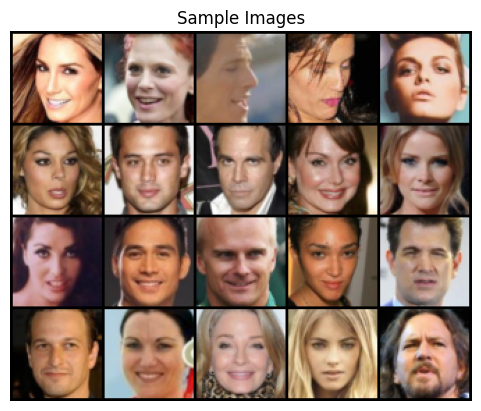

In [ ]:
# access the kaggle.json API key from the main folder of your google drive
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json




# download the dataset from kaggle
!kaggle datasets download -d zuozhaorui/celeba
!mkdir ./data
!unzip -q celeba.zip -d ./data/celeba

# load dataset using ImageFolder dataset
class CelebATransform:
    '''
    Crops around the face and resizes to IMG_HxIMG_W. Output is a tensor of shape (3, IMG_H, IMG_W) scaled to [0, 1]
    '''
    def __call__(self, img):
        img = torchvision.transforms.functional.crop(img, top=60, left=25, height=128, width=128)
        img = torchvision.transforms.functional.resize(img, (IMG_H, IMG_W))
        img = torchvision.transforms.functional.to_tensor(img)
        # img = torchvision.transforms.functional.normalize(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        return img

celeba = torchvision.datasets.ImageFolder(root='./data/celeba', transform=CelebATransform())

# visualize
grid_x = 5
grid_y = 4

samples = torch.stack([celeba[i][0] for i in range(grid_x*grid_y)])

img = torchvision.utils.make_grid(samples, grid_x, normalize=True, value_range=(0, 1))
plt.title(f'Sample Images')
plt.axis('off')
plt.imshow(img.permute(1,2,0).cpu())

### Train model

Checkpoint loaded. Resuming from training step 79150.
17:03:36 Begin Training
Training complete.


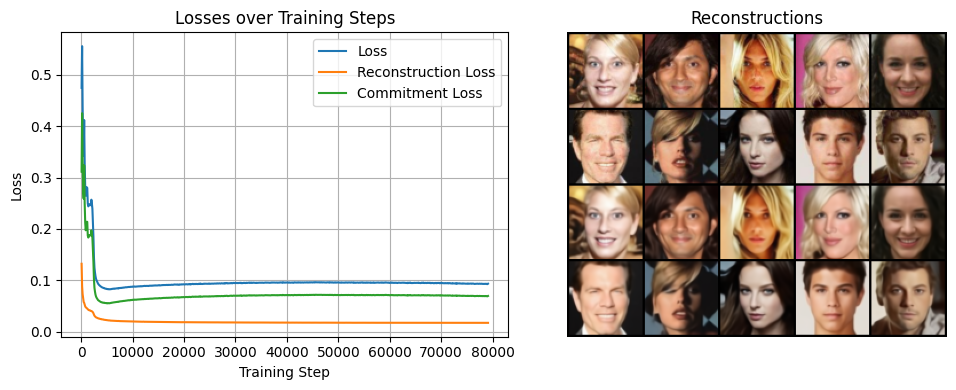

In [ ]:
from time import strftime

# Initialize and train a model. If you just want to load one from a checkpoint and not train, set EPOCHS = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# training hyperparemeters
EPOCHS = 0
BATCH_SIZE = 256
BETA = 0.1

# logging/saving hyperparemters
LOG_INTERVAL = 100
SAVE_INTERVAL = 1000
CHECKPOINT_DIR = '/content/drive/MyDrive/vq_models_large' #vq_models_large # vq_models

CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, 'checkpoint.pt')
LOAD_FROM_CHECKPOINT = True

dataloader = torch.utils.data.DataLoader(celeba, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
encoder = Encoder()
decoder = Decoder()
quantizer = Quantizer(use_EMA=True, batch_size=BATCH_SIZE)
model = VQ_VAE(encoder, decoder, quantizer, use_EMA=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

training_losses = []
training_steps = 0
running_losses = [0.0, 0.0, 0.0]

# load from checkpoint
if LOAD_FROM_CHECKPOINT:
    if not os.path.exists(CHECKPOINT_PATH):
        print(f'WARNING: Checkpoint not found at {CHECKPOINT_PATH}!')
    else:
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)

        model.load_state_dict(checkpoint['model_state'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        training_steps = checkpoint['training_steps']
        training_losses = checkpoint['training_losses']
        running_losses = checkpoint['running_losses']

        print(f'Checkpoint loaded. Resuming from training step {training_steps}.')

total_steps = training_steps + len(dataloader) * EPOCHS

# training loop
print(f'{strftime('%H:%M:%S')} Begin Training')
model.train()
for epoch in range(EPOCHS):
    for batch_idx, batch in enumerate(dataloader):
        # training step
        images, _ = batch
        images = images.to(device)

        reconstruction_loss, commitment_loss, codebook_loss = model(images)
        if model.use_EMA:
            loss = reconstruction_loss + BETA * commitment_loss + codebook_loss
        else:
            loss = reconstruction_loss + BETA * commitment_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_steps += 1

        running_losses[0] += loss.item()
        running_losses[1] += reconstruction_loss.item()
        running_losses[2] += commitment_loss.item()

        # logging step
        if training_steps % LOG_INTERVAL == 0:
            avg_losses = [loss / LOG_INTERVAL for loss in running_losses]
            running_losses = [0.0, 0.0, 0.0]
            training_losses.append((training_steps, avg_losses))
            with torch.no_grad():
                p = model.quantizer.N / model.quantizer.N.sum() * 512
                print(f'{strftime('%H:%M:%S')} TRAINING Step [{training_steps}/{total_steps}]; Loss: {avg_losses[0]:.4f}; Commitment: {avg_losses[2]:.4f}; Usage (min/med/max/dead): {p.min().item():.2f}, {p.median().item():.2f}, {p.max().item():.2f}, {torch.sum(p < 0.01) / 512 * 100:.0f}%')

        # saving step
        if training_steps % SAVE_INTERVAL == 0 or batch_idx == len(dataloader) - 1:
            checkpoint = {
                'training_steps': training_steps,
                'model_state': model.state_dict(),
                'optimizer_state': optimizer.state_dict(),
                'training_losses': training_losses,
                'running_losses': running_losses,
            }

            torch.save(checkpoint, CHECKPOINT_PATH)
            print(f'Checkpoint saved at step {training_steps} to {CHECKPOINT_PATH}')

            # visualize reconstructions
            grid_x = 5
            grid_y = 2

            samples, _ = next(iter(dataloader))
            samples = samples[:grid_x * grid_y // 2].to(device)

            model.eval()
            reconstructed = model.reconstruct(samples)
            model.train()

            images = torch.cat((samples, reconstructed), dim=0)
            img = torchvision.utils.make_grid(images, grid_x, normalize=True, value_range=(0, 1))

            plt.title(f'Reconstructions at step {training_steps}')
            plt.axis('off')
            plt.imshow(img.permute(1,2,0).cpu())
            plt.show()

print(f'Training complete.')

# Prepare loss data
steps_list = [item[0] for item in training_losses]
avg_losses_list = [item[1] for item in training_losses]

steps = np.array(steps_list)
losses = np.array(avg_losses_list)   # shape: (num_steps, 3)

# Prepare reconstructions
grid_x = 5
grid_y = 4

samples, _ = next(iter(dataloader))
samples = samples[:grid_x * grid_y // 2].to(device)

model.eval()
reconstructed = model.reconstruct(samples)

images = torch.cat((samples, reconstructed), dim=0)
img = torchvision.utils.make_grid(images, grid_x, normalize=True, value_range=(0, 1))

# Side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Loss curves
axes[0].plot(steps, losses[:, 0], label='Loss')
axes[0].plot(steps, losses[:, 1], label='Reconstruction Loss')
axes[0].plot(steps, losses[:, 2], label='Commitment Loss')

axes[0].set_xlabel('Training Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Losses over Training Steps')
axes[0].legend()
axes[0].grid(True)

# Reconstructions
axes[1].imshow(img.permute(1, 2, 0).cpu())
axes[1].set_title('Reconstructions')
axes[1].axis('off')

plt.tight_layout()
plt.show()

### Compute CelebA embeddings

In [ ]:
from tqdm import tqdm

celeba_indices = []

model.eval()
for batch in tqdm(dataloader):
    images, _ = batch
    images = images.to(device)
    indices = model.compute_indices(images)
    celeba_indices.append(indices.view(-1, LATENT_W * LATENT_H).cpu())

print('Concatenating...')
celeba_indices = torch.cat(celeba_indices, dim=0)
print('Shape:', celeba_indices.shape)
celeba_indices = celeba_indices.to(torch.uint16)
print('Saving...')
torch.save(celeba_indices, os.path.join(CHECKPOINT_DIR, "celeba_vq_indices_uint16n.pt"))w

100%|██████████| 1583/1583 [01:27<00:00, 18.12it/s]


Concatenating...
Shape: torch.Size([405198, 256])
Saving...


### Random Image Generation with Uniform Prior

In [ ]:
# visualize
grid_x = 5
grid_y = 4

model.eval()
samples = torch.randint(0, NUM_EMBEDDINGS, (grid_x*grid_y, 8, 8)).to(device)
with torch.no_grad():
    embeddings = model.quantizer.get_embeddings(samples)
    images = model.decoder(embeddings)

img = torchvision.utils.make_grid(images, grid_x, normalize=True, value_range=(0, 1))
plt.title(f'Images from uniform prior')
plt.axis('off')
plt.imshow(img.permute(1,2,0).cpu())

AttributeError: 'Quantizer' object has no attribute 'get_embeddings'